<a href="https://colab.research.google.com/github/ram130849/GANs/blob/main/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import imageio

In [9]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])
to_image = transforms.ToPILImage()
data = MNIST(root='./data/', train=True, download=True, transform=transform)
data_loader = DataLoader(data, batch_size=64, shuffle=True)

device = 'cuda'

In [10]:
class Generator(nn.Module):
    def __init__(self) -> None:
        super(Generator,self).__init__()
        self.n_features = 100
        self.n_out = 784
        self.model = nn.Sequential(
              nn.Linear(self.n_features,256),
              nn.LeakyReLU(0.2),
              nn.Linear(256,512),
              nn.LeakyReLU(0.2),
              nn.Linear(512,1024),
              nn.LeakyReLU(0.2),
              nn.Linear(1024,self.n_out),
              nn.Tanh()
        )
    def forward(self,x):
        x = self.model(x)
        x = x.view(-1,1,28,28)
        return x

In [11]:
class Discriminator(nn.Module):
    def __init__(self) -> None:
        super(Discriminator,self).__init__()
        self.n_in = 784
        self.n_out = 1
        self.model = nn.Sequential(
            nn.Linear(self.n_in,1000),
            nn.LeakyReLU(0.2),
            nn.Linear(1000,512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,self.n_out)
        )
    def forward(self,x):
        x = x.view(-1,784)
        x = self.model(x)
        return x

In [15]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [13]:
actor = Generator()
critic = Discriminator()

actor = actor.to(device)
critic = critic.to(device)

alpha = 5e-5
g_optim = optim.RMSprop(actor.parameters(),lr=alpha)
d_optim = optim.RMSprop(critic.parameters(),lr=alpha)

In [16]:
actor.apply(init_weights)
critic.apply(init_weights)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=1000, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=1000, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [17]:
g_losses = []
d_losses = []
images = []

def noise(n,n_features=100):
      return torch.randn(n,n_features).to(device)

In [18]:
no_epochs = 250
n_critic = 5
test_noise = noise(64)

actor.train()
critic.train()
for epoch in range(no_epochs):
    a_error = 0.0
    c_error = 0.0
    for idx,data in enumerate(data_loader):
        imgs,labels = data
        n = len(imgs)
        fake_data = actor(noise(n)).detach()
        real_data = imgs.to(device)
        d_optim.zero_grad()
        err_real = critic(real_data).mean()
        err_fake = critic(fake_data).mean()
        total_error = -(err_real-err_fake)
        total_error.backward()
        d_optim.step()
        for p in critic.parameters():
            p.data.clamp(-0.01,0.01)
        total_error = -total_error
        c_error+=total_error
        if((idx+1)%n_critic==0):
            fake_data = actor(noise(n))
            g_optim.zero_grad()
            error = -critic(fake_data).mean()
            error.backward()
            g_optim.step()
            a_error+=error
    if(epoch%5==0):
        img = actor(test_noise).cpu().detach()
        img = make_grid(img)
        images.append(to_image(img))
        a_error.cpu()
        g_losses.append(a_error.cpu().detach().numpy())
        c_error.cpu()
        d_losses.append(c_error.cpu().detach().numpy())
    print('Epoch {}: G_loss: {:.4f} C_loss: {:.4f}'.format(epoch, a_error, c_error))
    
print('Training Finished')
torch.save(actor.state_dict(), 'mnist_generator.pth')


Epoch 0: G_loss: -104776.5547 C_loss: 33413.8984
Epoch 1: G_loss: -87063.0625 C_loss: 1182256.0000
Epoch 2: G_loss: -2370823.2500 C_loss: 4590826.0000
Epoch 3: G_loss: -4976302.5000 C_loss: 9757119.0000
Epoch 4: G_loss: -12262008.0000 C_loss: 25504372.0000
Epoch 5: G_loss: -18520168.0000 C_loss: 65809916.0000
Epoch 6: G_loss: -33424686.0000 C_loss: 89269744.0000
Epoch 7: G_loss: -60383012.0000 C_loss: 115084600.0000
Epoch 8: G_loss: -95000952.0000 C_loss: 186350368.0000
Epoch 9: G_loss: -111788264.0000 C_loss: 274631744.0000
Epoch 10: G_loss: -173788960.0000 C_loss: 323915040.0000
Epoch 11: G_loss: -218141120.0000 C_loss: 434749696.0000
Epoch 12: G_loss: -291995392.0000 C_loss: 429949216.0000
Epoch 13: G_loss: -386321952.0000 C_loss: 598764608.0000
Epoch 14: G_loss: -380047072.0000 C_loss: 934295744.0000
Epoch 15: G_loss: -576743744.0000 C_loss: 711286144.0000
Epoch 16: G_loss: -724567168.0000 C_loss: 1072796224.0000
Epoch 17: G_loss: -745100992.0000 C_loss: 1176947712.0000
Epoch 18: G

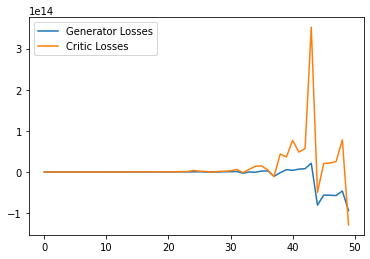

In [19]:
plt.clf()
plt.plot(g_losses, label='Generator Losses')
plt.plot(d_losses, label='Critic Losses')
plt.legend()
plt.savefig('loss.png')
imageio.mimsave('progress.gif', [np.array(i) for i in images])

In [25]:
# plt.plot(images[-1].)
images[-1].show()

AttributeError: ignored

In [ ]:
b